In [1]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import utils

In [3]:
importlib.reload(utils)

<module 'utils' from '/Users/vladimirknazevskij/Programming/HSE/subjects/py_adv/hw1/utils/__init__.py'>

## Анализ исторических данных

In [4]:
df = pd.read_csv('temperature_data.csv')
cities = sorted(df['city'].unique())

#### Исследование параллельности

Сравним скорость последовательного и параллельного анализа данных. Выводы и суть описаны в комментариях в Anytask.

In [5]:
%%timeit
utils.all_cities_data_analysis_sequential(df, cities)

143 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit
utils.all_cities_data_analysis_parallel(df, cities)

101 ms ± 5.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
results_sequential = utils.all_cities_data_analysis_sequential(df, cities)
results_parallel = utils.all_cities_data_analysis_parallel(df, cities)

In [8]:
(results_sequential.fillna(0) == results_parallel.fillna(0)).all().all()

True

В клетках выше мы проверили, что функции выдают абсолютно идентичные данные (nan образуются в скользящем среднем, и их нужно заполнить, иначе их проверка на равенство дает False).

#### Пример анализа

Анализ ниже полностью аналогичен тому, который реализован в streamlit.

In [5]:
city_df = df[df['city'] == 'Moscow']
city_df = utils.single_city_data_analysis(city_df)

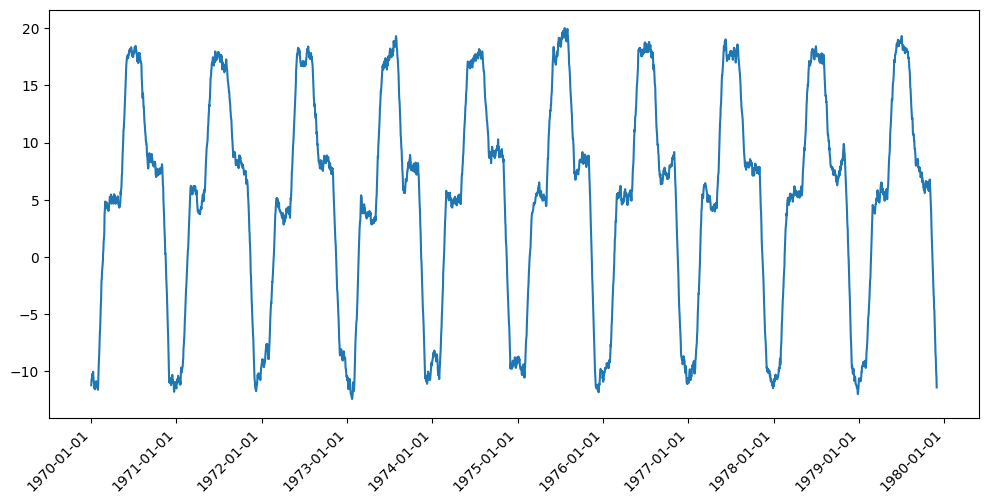

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(city_df[['timestamp', 'moving_average']].dropna().set_index('timestamp'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate(rotation=45)

In [6]:
season_profiles = city_df.groupby('season').first().reset_index()[['season', 'mean', 'std']]
season_profiles

,season,mean,std
0,autumn,7.847183,4.987566
1,spring,4.859202,4.906178
2,summer,17.726901,4.896939
3,winter,-10.211801,5.214480


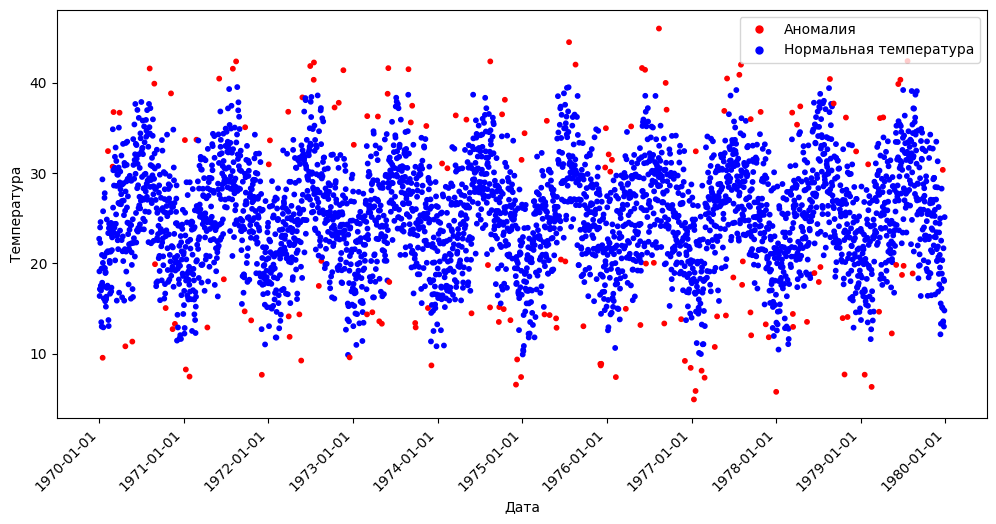

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['red' if anomaly else 'blue' for anomaly in city_df['anomaly']]
ax.scatter(city_df['timestamp'], city_df['temperature'], s=10, c=colors)
ax.set_xlabel('Дата')
ax.set_ylabel('Температура')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate(rotation=45)
red_patch = plt.Line2D([0], [0], color='red', marker='o', linestyle='', markersize=5, label='Аномалия')
blue_patch = plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=5, label='Нормальная температура')
ax.legend(handles=[red_patch, blue_patch])
plt.show()

## Мониторинг текущей температуры

Посмотрим на примере Москвы.

In [7]:
import json

with open("config.json", "r") as f:
    config = json.load(f)

api_key = config.get("OPENWEATHER_API_KEY")

In [17]:
temp, season = utils.curr_temperature_sync(api_key, 'Moscow'); temp, season

(0.4, 'winter')

In [9]:
curr_mean = season_profiles[season_profiles['season'] == season]['mean'].item()
curr_std = season_profiles[season_profiles['season'] == season]['std'].item()
if temp < curr_mean + 2 * curr_std and temp > curr_mean - 2 * curr_std:
    print('Температура нормальная')
else:
    print('Аномалия')

Аномалия


Теперь на примере разных городов.

In [12]:
for city in ['Berlin', 'Cairo', 'Dubai', 'Beijing', 'New York', 'Rio de Janeiro']:
    city_df = results_sequential[results_sequential['city'] == city]
    season_profiles = city_df.groupby('season').first().reset_index()[['season', 'mean', 'std']]
    temp, season = utils.curr_temperature_sync(api_key, city)
    curr_mean = season_profiles[season_profiles['season'] == season]['mean'].item()
    curr_std = season_profiles[season_profiles['season'] == season]['std'].item()
    if temp < curr_mean + 2 * curr_std and temp > curr_mean - 2 * curr_std:
        print(f'{city}: {temp}, температура нормальная')
    else:
        print(f'{city}: {temp}, аномалия')
        

Berlin: 1.4, температура нормальная
Cairo: 14.42, температура нормальная
Dubai: 22.96, температура нормальная
Beijing: 2.94, температура нормальная
New York: 12.27, аномалия
Rio de Janeiro: 25.42, температура нормальная


Убедимся, что асинхронный метод так же работает

In [13]:
import nest_asyncio
nest_asyncio.apply()

In [32]:
temp, season = await curr_temperature_async(api_key, 'Moscow'); temp, season

(0.4, 'winter')